In [1]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data_guess, to_pyg_data_true
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE
from torch.nn import Linear, Sequential, ReLU, LeakyReLU
from torch.optim import Adam

In [2]:
# run only if new data is desired
ode_dim = 3
n_data = 10
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,10000)

dataset_train = []
for i in range(0,len(x_train)):
    p = param[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset_train.append(to_pyg_data_true(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset_train,batch_size=32,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    p = param_test[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset.append(to_pyg_data_true(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [3]:
from torch.nn import Linear, Sequential, LeakyReLU
from torch_geometric.nn import GATConv

class GCNEncoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels=10):
        super(GCNEncoder, self).__init__()

        self.gcn1 = GCNConv(in_channels,4*out_channels)
        self.gcn2 = GCNConv(4*out_channels,out_channels)

    def forward(self, data, edge_index):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.gcn1(x, edge_index=edge_index)
        x = torch.nn.functional.leaky_relu(x)
        x = self.gcn2(x,edge_index=edge_index)
        return torch.nn.functional.leaky_relu(x)

In [5]:
class MLPDecoder(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim=16):
        super(MLPDecoder, self).__init__()
        # Define the MLP for decoding
        self.mlp = Sequential(
            Linear(2 * embedding_dim, hidden_dim),
            LeakyReLU(),
            Linear(hidden_dim, 1)  # Output a single value (edge weight) for each pair
        )

    def forward(self, z, edge_index):
        """
        z: Node embeddings of shape (num_nodes, embedding_dim)

        Returns:
        adj_pred: Predicted adjacency matrix of shape (num_nodes, num_nodes)
        """
        # Extract source and target node embeddings based on edge_index
        src_nodes = z[edge_index[0]]  # Shape: (num_edges, embedding_dim)
        tgt_nodes = z[edge_index[1]]  # Shape: (num_edges, embedding_dim)

        # Concatenate source and target embeddings for each pair
        edge_features = torch.cat([src_nodes, tgt_nodes], dim=-1)  # Shape: (num_nodes, num_nodes, 2 * embedding_dim)

        # Pass through MLP to predict edge weights
        edge_weights = self.mlp(edge_features).squeeze(-1)  # Shape: (num_nodes, num_nodes)

        return edge_weights

In [6]:
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import to_dense_adj

model = GAE(GCNEncoder(2*n_data,30),MLPDecoder(30))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = torch.nn.MSELoss()

train_loss = []

for epoch in range(3000):
    model.train()

    tr_loss = 0
    full_loss = 0
    for data in loader:
        data = data.to(device)
        batch_size = data.batch.max().item()+1
        optimizer.zero_grad()

        z = model.encode(data, data.edge_index)

        recon_part = model.decode(z,data.edge_index)

        loss = criterion(recon_part,data.edge_attr.flatten())

        train_loss.append(loss)
        full_loss += loss

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

        with torch.no_grad():
            latent_embeddings = z.cpu().detach().numpy()
    #train_loss.append(full_loss)
    print(full_loss.item())

for data in dataset_train:
    z = model.encode(data.to(device), data.edge_index)

    recon = model.decode(z,data.edge_index)

    print(recon)

941.516357421875
918.6671142578125
928.7844848632812
863.0372314453125
839.796875
839.0390625
831.8042602539062
831.068115234375
833.0655517578125
825.5466918945312
824.5922241210938
825.8497924804688
824.79248046875
822.0588989257812
821.3169555664062
822.8296508789062
820.23486328125
825.6266479492188
822.2275390625
816.4612426757812
817.3601684570312
817.825927734375
816.9058837890625
813.405029296875
813.629638671875
814.378662109375
810.0739135742188
808.6719360351562
812.0331420898438
811.9072875976562
807.7435913085938
809.0551147460938
806.2484741210938
802.3843383789062
805.2403564453125
801.4417724609375
802.1781005859375
801.46044921875
799.0782470703125
800.7298583984375
794.18408203125
797.7503662109375
796.4083862304688
795.42919921875
793.9171752929688
791.8351440429688
791.0917358398438
790.4794921875
787.6633911132812
789.9301147460938
786.4058837890625
785.5150146484375
784.519775390625
783.7355346679688
784.9216918945312
784.7363891601562
781.923828125
780.5538330078

KeyboardInterrupt: 

(96, 30)


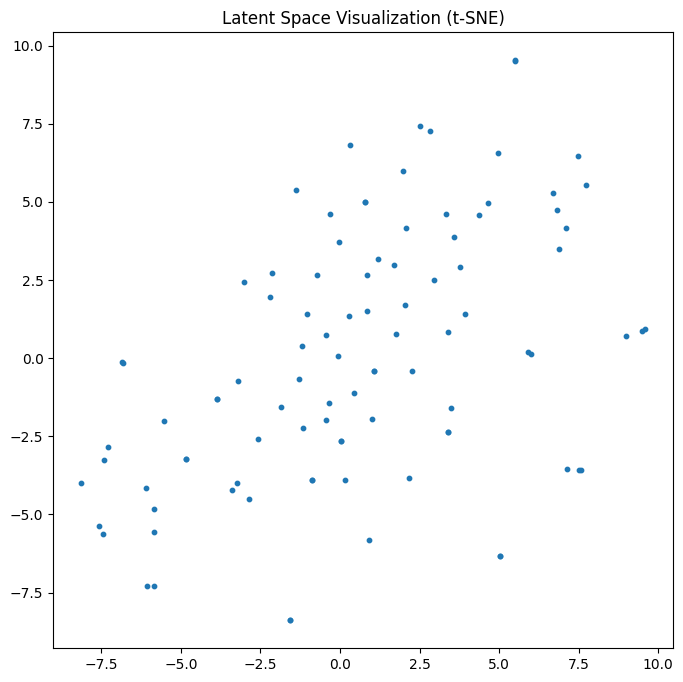

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print(latent_embeddings.shape)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(latent_embeddings)

plt.figure(figsize=(8, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)
plt.title("Latent Space Visualization (t-SNE)")
plt.show()

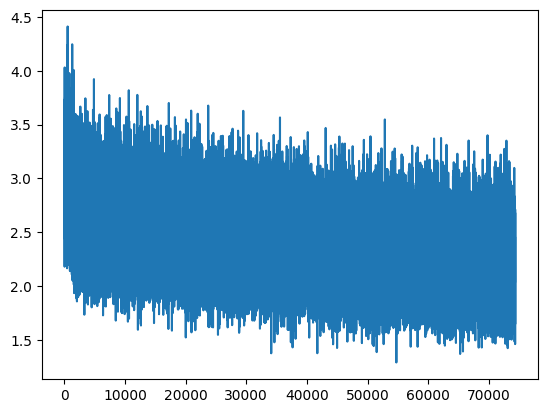

In [8]:
import matplotlib.pyplot as plt

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.show()

In [12]:
def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,100)

val_dataset = []
param_list = []

for i in range(0,len(x_val)):
    p = param_val[i]
    param_vec = torch.cat((p.Win.flatten(), p.Wout.flatten(), p.bin, p.bout, p.gamma)).numpy()
    param_list.append(param_vec)
    val_dataset.append(to_pyg_data_true(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset,batch_size=1)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

changed = 0
fixed = 0
destroyed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    batch = batch.to(device)
    z = model.encode(batch, batch.edge_index)
    
    recon = model.decode(z,batch.edge_index)
    Ahat = recon.flatten()

    print(batch.edge_attr)
    print(Ahat)

    # Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.edge_attr)
    Ahat = get_adjacency(Ahat)
    print(Ahat)
    print(A)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1

    for i in range(0,len(A)):

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1   
            
        elems_total += 1

print(correct/total)
print(elem_wise/elems_total)

tensor([0.9307, 1.1438, 2.1619, 1.4213, 3.5308], device='cuda:0')
tensor([0.4095, 0.3493, 0.4689, 0.3791, 0.4434], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([1., 0., 1., 1., 1.], device='cuda:0', dtype=torch.float64)
tensor([0., 0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)
tensor([ 1.2270, -1.1391,  1.5483,  1.6526, -0.4594], device='cuda:0')
tensor([1.9916, 0.8750, 0.4237, 0.8750, 1.9916], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([1., 0., 0., 0., 1.], device='cuda:0', dtype=torch.float64)
tensor([ 1., -1.,  1.,  1.,  0.], device='cuda:0', dtype=torch.float64)
tensor([ 1.2431, -1.3562, -0.6758, -2.5677, -1.2912], device='cuda:0')
tensor([-1.4939, -0.7903, -1.6156, -1.6240, -0.8344], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([-1.,  0., -1., -1.,  0.], device='cuda:0', dtype=torch.float64)
tensor([ 0.,  0.,  0., -1.,  0.], device='cuda:0', dtype=torch.float64)
tensor([0.9917, 2.7175, 1.3923, 1.3562], device='cuda:0')
tensor([0